# SAM for Lia

There are different ways to tell SAM how to segment 2D images:

* Seed points
* Segmentation Masks
* Bounding Boxes
* Logits
* Automatic Mask Generation

For 3D images I currently do not believe, that a slicewise 2D algorithm is the best solution, as it:
* has slice artifacts most of the time,
* has problems with dealing with nonconvex shapes,
* is dependent on the axis an the direction in which the image is processed.

### Preparation

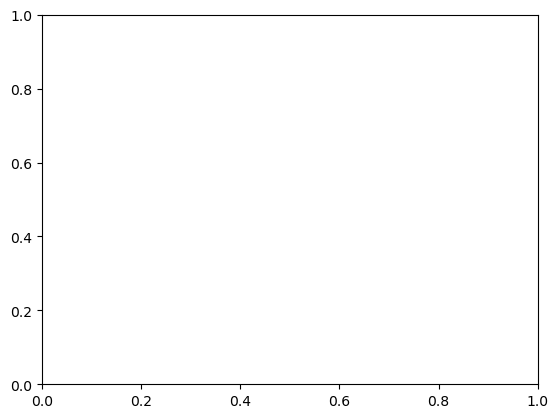

In [6]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
from tifffile import imread, imwrite
import torch
import skimage.measure
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

from utils.plotting import show_all_masks, show_all_points
from utils.get_label_list import get_label_list
from utils.get_point_list import get_point_list
from utils.SAM.reference_to_sam_mask import reference_to_sam_mask

no_points = np.empty((0, 2))

from utils.SAM.show_anns import show_anns;

## Seed points

First we need initial seed points for some layer. These can be either user provided or automatically generated.
Below I create some seed points automatically. This is very dependent on the images.

In [19]:

nSlice = 200
image = imread("../../KI-Morph_Container/fakeSDS/datasets/Medaka/volumes/673.tif")


# sam = sam_model_registry["vit_b"](checkpoint="SAM/sam_vit_b_01ec64.pth") # base
# sam = sam_model_registry["vit_l"](checkpoint="SAM/sam_vit_l_0b3195.pth") # large

# huge, since we do not have compute problems we use the largest architecture


def segmentSlice(imageSlice):
    """
    Segments a slice of the image using the SAM model
    """

    sam = sam_model_registry["vit_h"](
        checkpoint="../../KI-Morph_Container/fakeSDS/model/SAM/sam_vit_h_4b8939.pth"
    )
    predictor = SamPredictor(sam)

    predictor.set_image(
        np.repeat(np.expand_dims(torch.from_numpy(imageSlice), axis=2), 3, axis=2)
    )

    count = 5
    pad = 30
    points = [
        # Background points are selected along the border
        np.concatenate(
            (
                np.array(
                    (
                        np.repeat(pad, count),
                        np.linspace(pad, image.shape[0], count).astype("int"),
                    )
                ).transpose(),
                np.array(
                    (
                        np.repeat(image.shape[1] - pad, count),
                        np.linspace(pad, image.shape[0], count).astype("int"),
                    )
                ).transpose(),
                np.array(
                    (
                        np.linspace(pad, image.shape[1], count).astype("int"),
                        np.repeat(pad, count),
                    )
                ).transpose(),
                np.array(
                    (
                        np.linspace(pad, image.shape[1], count).astype("int"),
                        np.repeat(image.shape[0] - pad, count),
                    )
                ).transpose(),
            )
        ).tolist(),

        # Foreground points are local maxima of the intensity
        np.flip(
            peak_local_max(imageSlice, min_distance=20, num_peaks=10), axis=1
        ).tolist(),
    ]

    mask_list = []
    score_list = []
    logits_list = []

    # Loop over the two classes
    for i in range(2):

        # Conver the list of seed points to the SAM format
        labels = get_label_list(points)

        # Run the SAM model
        masks, scores, logits = predictor.predict(
            point_coords=get_point_list(points),
            point_labels=np.where(labels == i, 1, 0),
            # multimask_output = True produces three segmentations, of increasing granularity
            multimask_output=False,
        )
        mask_list.append(masks)
        score_list.append(scores)
        logits_list.append(logits)

    # Combine the segmentations masks for the two labels into a single segmentation
    segmentation = torch.zeros(mask_list[0][0].shape)
    segmentation[mask_list[0][0]] = 1
    segmentation[mask_list[1][0]] = 2

    return segmentation, mask_list, score_list, logits_list, points

In [20]:
segmentation, mask_list, score_list, logits_list, points = segmentSlice(
    image[:, :, nSlice]
)

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


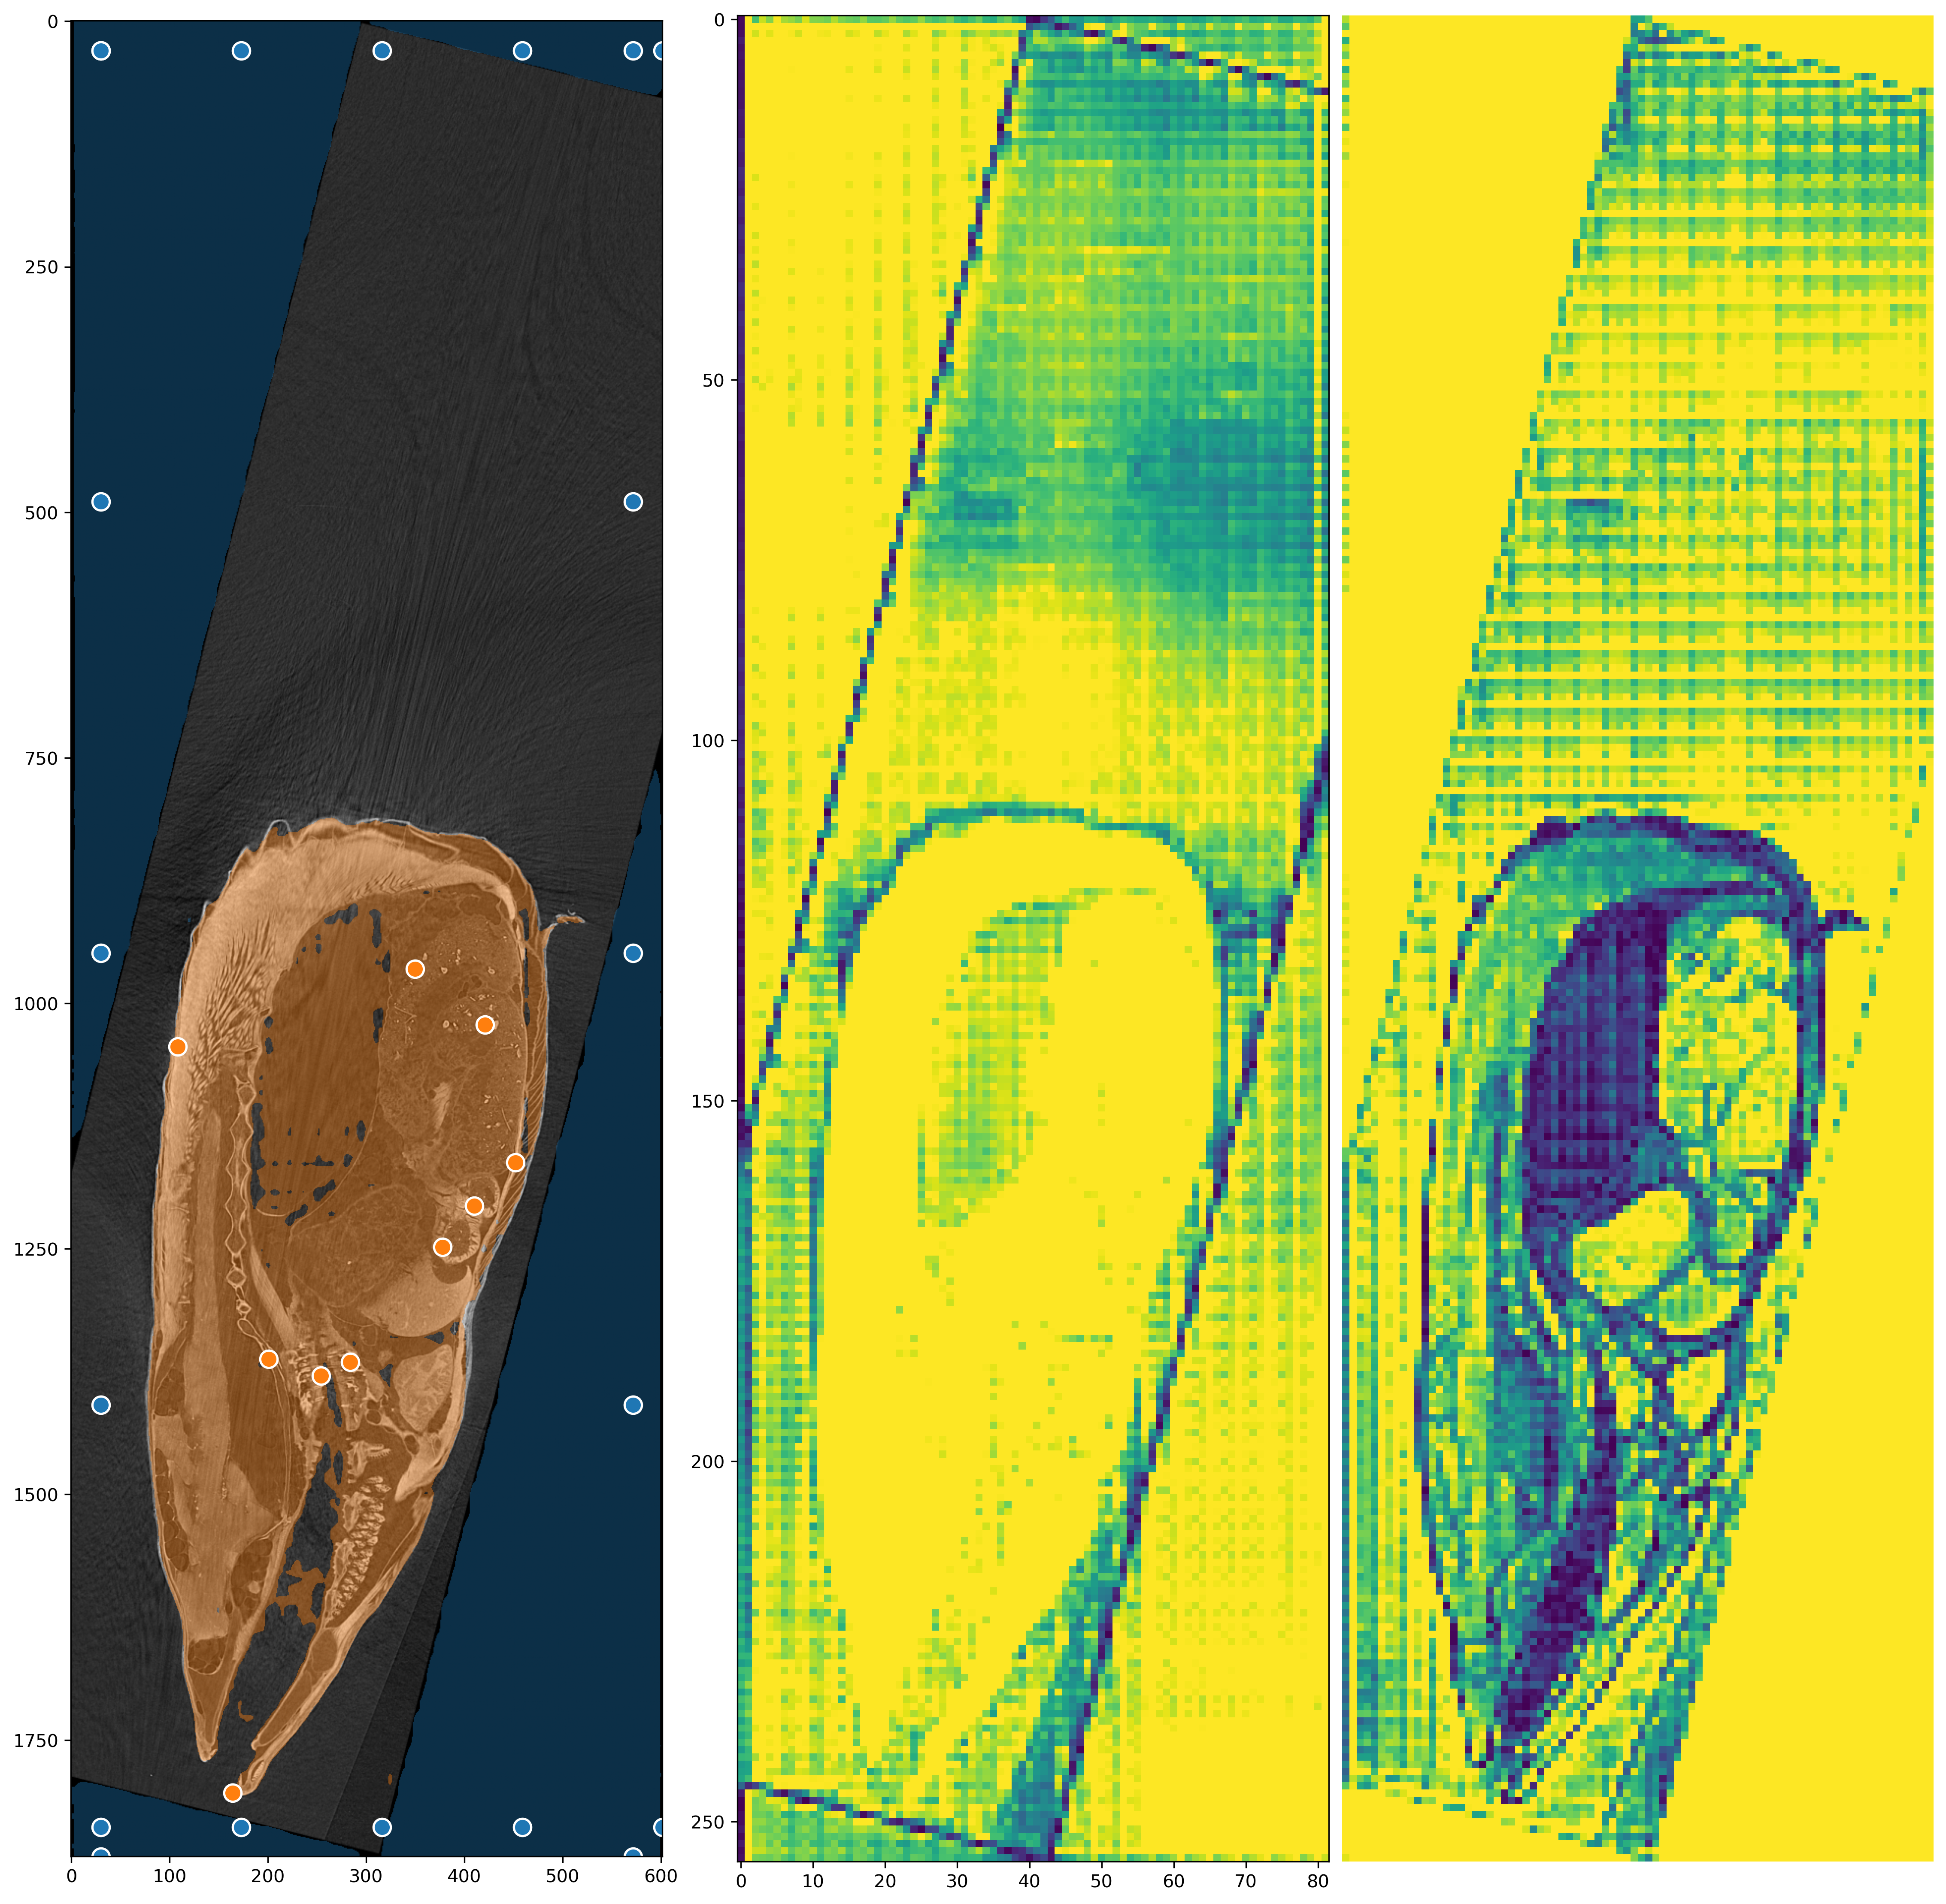

In [22]:
small_shape = (np.array(image.shape[:2]) * 256 / np.max(image.shape)).astype(np.uint16)
fig, axs = plt.subplot_mosaic(
    [
        ["plot", "logits0", "logits1"],
    ],
    layout="constrained",
    figsize=(15, 15),
    dpi=300,
)


axs["plot"].imshow(
    np.expand_dims(image[:, :, nSlice], axis=0).repeat(3, axis=0).transpose(1, 2, 0)
)
show_all_points(points, axs["plot"])
show_all_masks(mask_list, axs["plot"])

axs["logits0"].imshow(
    np.abs(logits_list[0][0][: small_shape[0], : small_shape[1]]),
    cmap="viridis",
    interpolation="nearest",
    vmax=10,
)
axs["logits1"].imshow(
    np.abs(logits_list[1][0][: small_shape[0], : small_shape[1]]),
    cmap="viridis",
    interpolation="nearest",
    vmax=10,
)

### Segment several slices of the image



In [24]:

full_segmentation = torch.zeros(image.shape)

# for i in range(image.shape[2]):
for i in tqdm(range(200, 210)):
    full_segmentation[:, :, i], _, _, _, _ = segmentSlice(image[:, :, i])

 10%|█         | 1/10 [00:10<01:37, 10.79s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


 20%|██        | 2/10 [00:21<01:27, 10.94s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


 30%|███       | 3/10 [00:32<01:16, 10.92s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


 40%|████      | 4/10 [00:43<01:05, 10.95s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


 50%|█████     | 5/10 [00:54<00:54, 10.96s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


 60%|██████    | 6/10 [01:05<00:43, 10.96s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


 70%|███████   | 7/10 [01:16<00:32, 10.99s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


 80%|████████  | 8/10 [01:27<00:22, 11.01s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


 90%|█████████ | 9/10 [01:38<00:10, 10.99s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


100%|██████████| 10/10 [01:49<00:00, 10.97s/it]

[[[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]
  ...
  [False False False ...  True False False]
  [False False False ...  True False False]
  [False False False ...  True False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


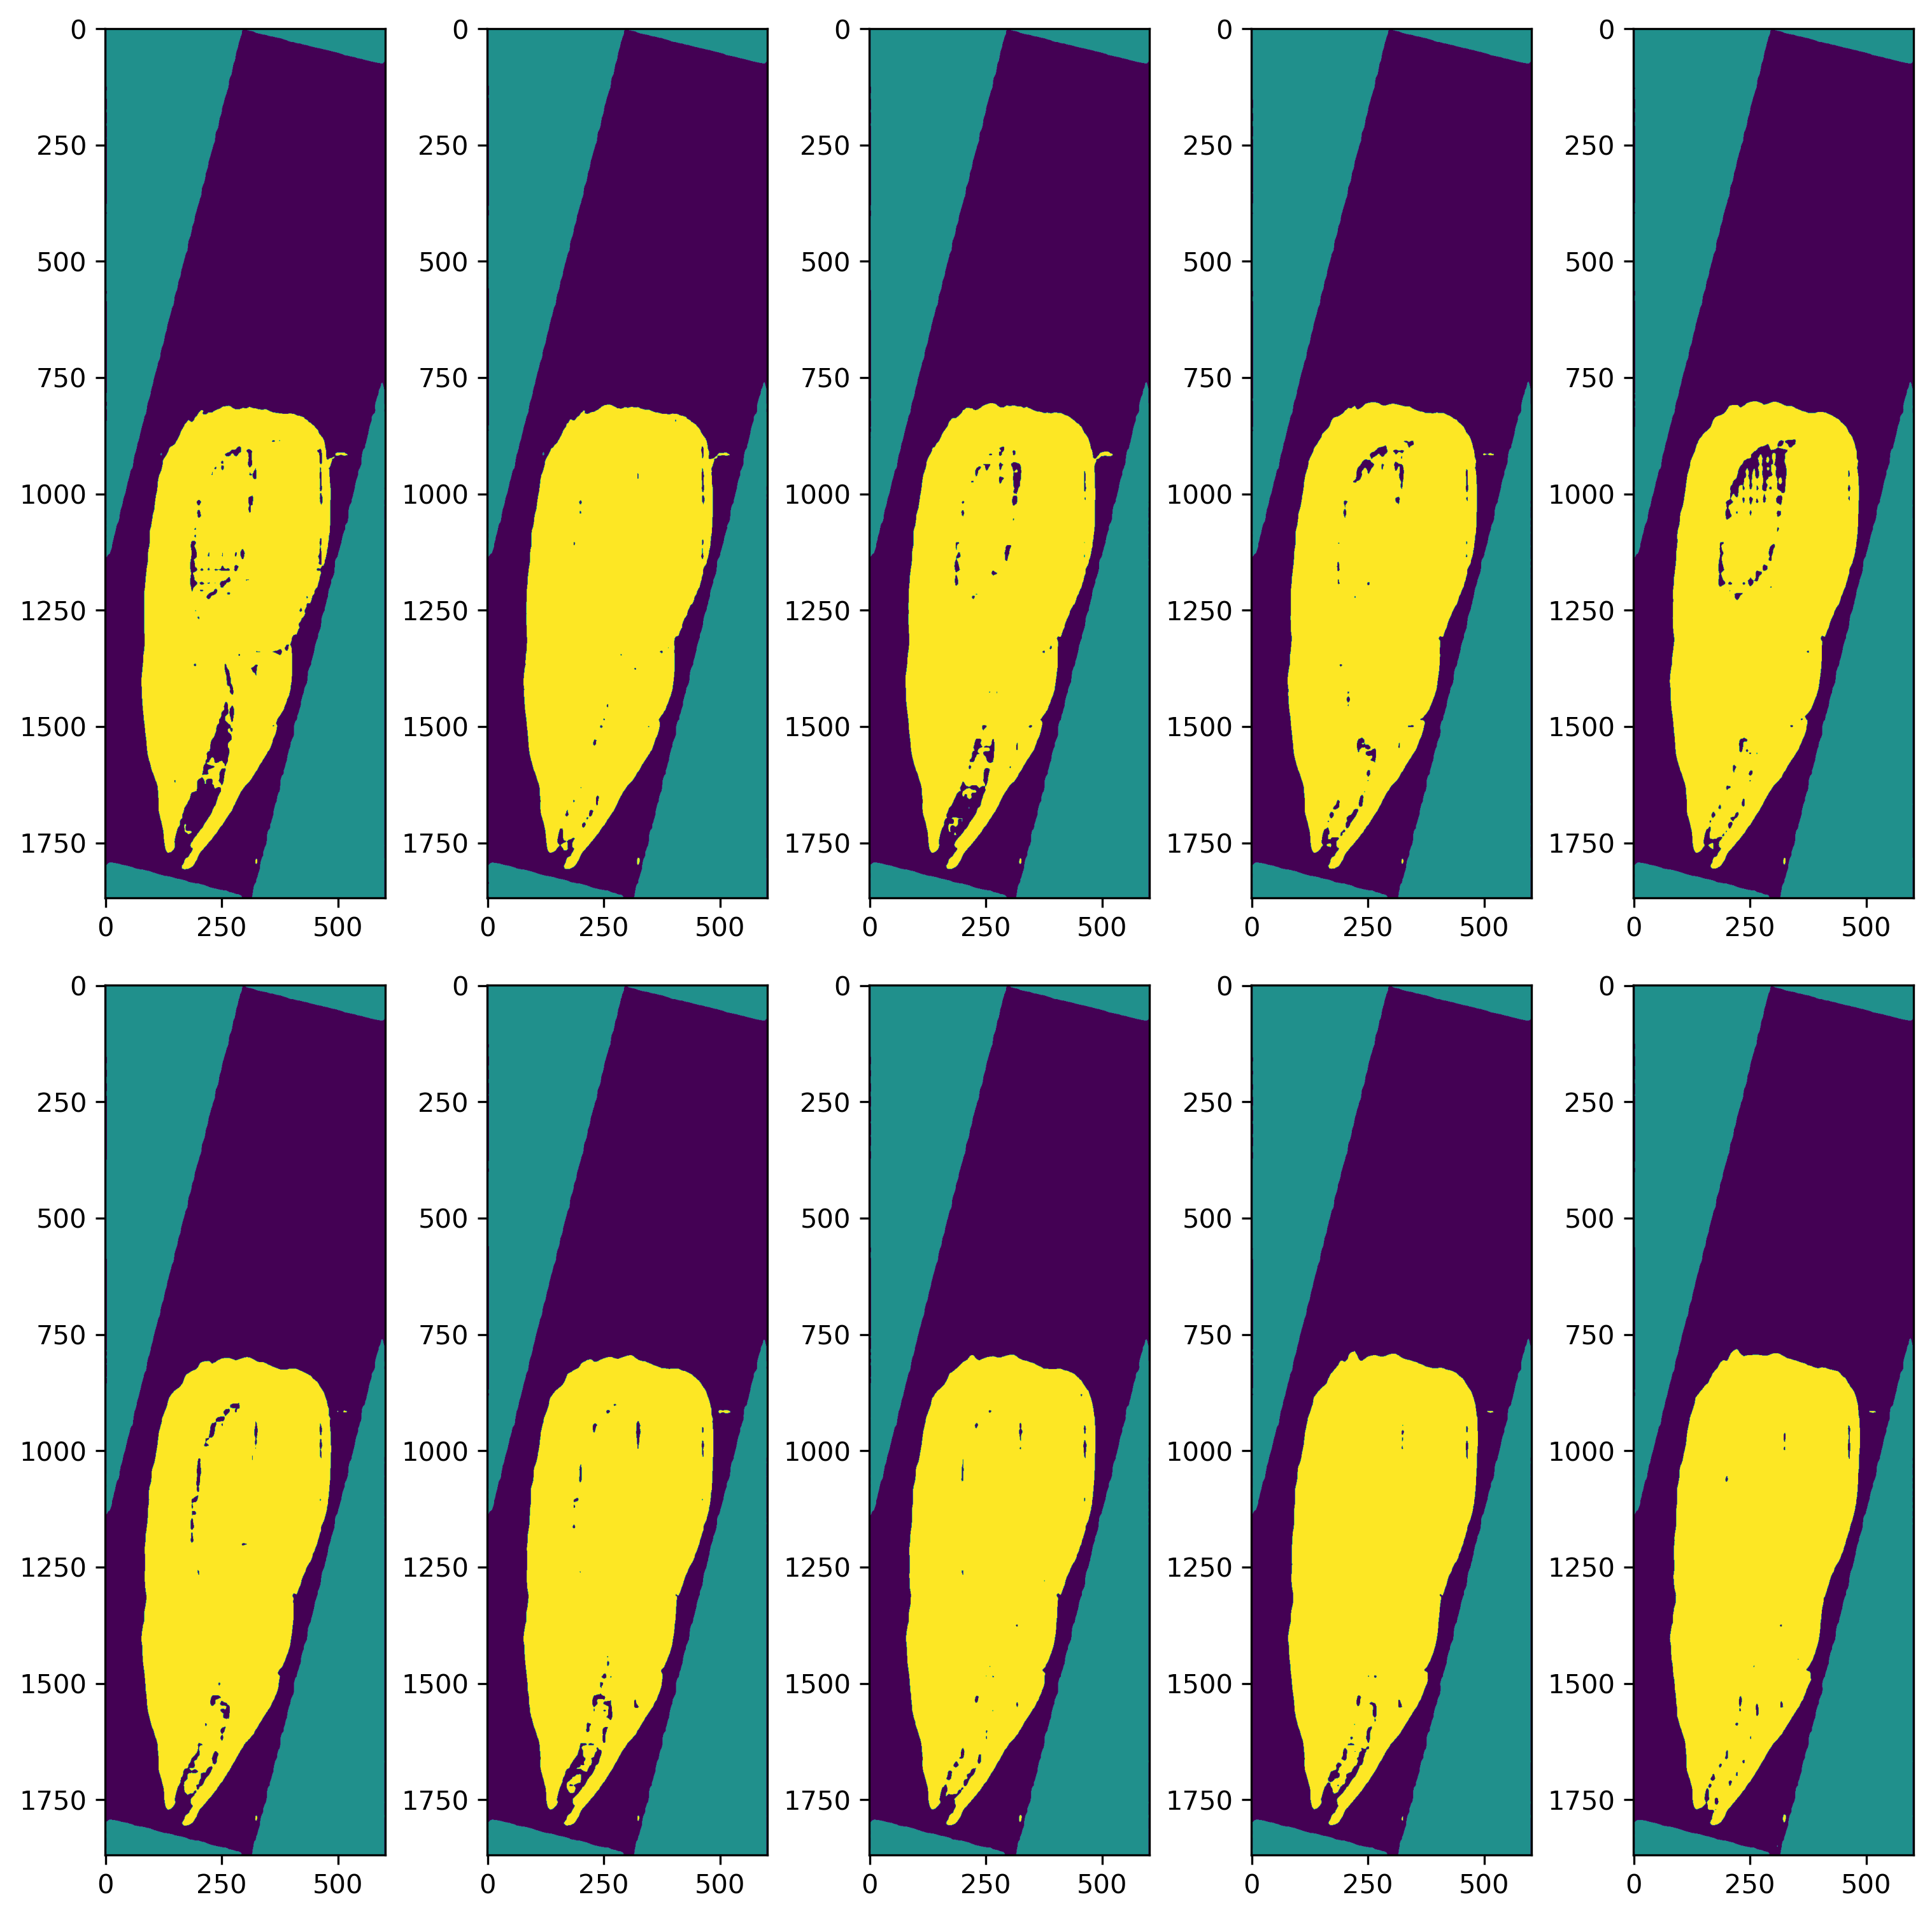

In [28]:
fig, axs = plt.subplot_mosaic(
    [
        [0, 1, 2, 3, 4,],
        [5, 6, 7, 8, 9,],
    ],
    layout="constrained",
    figsize=(10, 10),
    dpi=300,
)

for i in range(0, 10):
    axs[i].imshow(full_segmentation[:, :, 200 + i])

## Bounding Boxes

** Code here is proably not working as is, but the snippets should be helpful.**

In [ ]:
def getSliceFromVolume(volume, nSlice, axis):
    """
    Returns a slice from a volume along a given axis
    """
    if axis == 0:
        return volume[nSlice, :, :]
    elif axis == 1:
        return volume[:, nSlice, :]
    elif axis == 2:
        return volume[:, :, nSlice]
    else:
        raise ValueError("Axis must be 0, 1 or 2")

In [ ]:
def segmentVolume(image, *, sam_model="base", axis=0, initialSlice=200):
    """
    Segments a volume of the image using the SAM model
    """
    if sam_model == "base":
        sam = sam_model_registry["vit_b"](
            checkpoint="../../KI-Morph_Container/fakeSDS/model/SAM/sam_vit_b_01ec64.pth"
        )
    elif sam_model == "large":
        sam = sam_model_registry["vit_l"](
            checkpoint="../../KI-Morph_Container/fakeSDS/model/SAM/sam_vit_l_0b3195.pth"
        )
    elif sam_model == "huge":
        sam = sam_model_registry["vit_h"](
            checkpoint="../../KI-Morph_Container/fakeSDS/model/SAM/sam_vit_h_4b8939.pth"
        )
    else:
        raise ValueError("sam_model must be one of 'base', 'large', 'huge'")

    predictor = SamPredictor(sam)

    full_segmentation = np.zeros(image.shape)

    slices = [slice(None)] * 3
    slices[axis] = initialSlice

    # Segment the initial slice
    res = segmentSlice(image[tuple(slices)])
    masks = res[1][1][0]
    full_segmentation[tuple(slices)] = masks

    # Segment the slices after the initial slice
    for i in tqdm(range(initialSlice + 1, image.shape[axis])):
        predictor.set_image(
            np.repeat(
                np.expand_dims(torch.from_numpy(image[:, :, i]), axis=2), 3, axis=2
            )
        )
        # Get the bounding box of the previous segmentation
        # and use it to segment the current slice
        bbox = skimage.measure.regionprops(masks.astype(np.uint8))[0]["bbox"]
        masks, _, _ = predictor.predict(
            box=np.array(bbox)[[1, 0, 3, 2]],
            multimask_output=False,
        )
        masks = masks[0]
        full_segmentation[:, :, i] = masks

    masks = res[1][1][0]

    # Segment the slices before the initial slice
    for i in tqdm(range(initialSlice - 1, 0, -1)):
        predictor.set_image(
            np.repeat(
                np.expand_dims(torch.from_numpy(image[:, :, i]), axis=2), 3, axis=2
            )
        )
        bbox = skimage.measure.regionprops(masks.astype(np.uint8))[0]["bbox"]
        masks, _, _ = predictor.predict(
            box=np.array(bbox)[[1, 0, 3, 2]],
            multimask_output=False,
        )
        masks = masks[0]
        full_segmentation[:, :, i] = masks

    return full_segmentation

## New Points from Logits

Idea: Once slice $n$ is segmented we use the local maxima of the logits, i.e., the points where the algorithm is very sure, as seed points for the next slice.

In [ ]:
points_201 = [
    np.flip(
        # Select local maxima of the logits as seed points for the background
        peak_local_max(
            logits_list200[0][0][: small_shape[0], : small_shape[1]],
            min_distance=10,
            num_peaks=10,
        ),
        axis=1,
    ).tolist(),
    np.flip(
        # And the foreground
        peak_local_max(
            logits_list200[1][0][: small_shape[0], : small_shape[1]],
            min_distance=10,
            num_peaks=10,
        ),
        axis=1,
    ).tolist(),
]


labels_201 = get_label_list(points_201)

sam = sam_model_registry["vit_h"](
    checkpoint="../../KI-Morph_Container/fakeSDS/model/SAM/sam_vit_h_4b8939.pth"
)
predictor = SamPredictor(sam)


predictor.set_image(
    np.repeat(np.expand_dims(torch.from_numpy(image[:, :, 201]), axis=2), 3, axis=2)
)

mask_list_201 = []
score_list_201 = []
logits_list_201 = []

# Loop over the two classes
for i in range(2):

    # Use the logit generate seed points normally.
    masks_201, scores_201, logits_201 = predictor.predict(
        point_coords=get_point_list(np.array(points_201) * 7.3),
        point_labels=np.where(labels_201 == i, 1, 0),
        multimask_output=False,
    )
    mask_list_201.append(masks_201)
    score_list_201.append(scores_201)
    logits_list_201.append(logits_201)

## Automatic Mask Generation

The idea of automatic mask generation ist that one does not have to provide any (semantic) input in order to generate the segmentation.
However, since we need a semantic segmentation, we would need to provide semantic information after the segmentation.

```mermaid
flowchart LR
    image1[Image] --> segmentation1[Segmentation] --> semantic1[Semanic Information]
```

The problems witht this approach are:
* The semantic information can help signigicantly in the segmentation process
* The segmentation is often very different for neighboring slices.



So my current approach is to provide the semantic information before the segmentation. 

```mermaid
flowchart LR
    image2[Image] --> semantic2[Semanic Information] --> segmentation2[Segmentation]
```

Nonetheless here is some code:

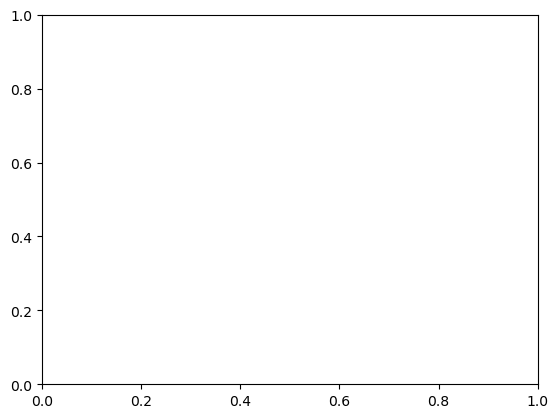

In [1]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from tifffile import imread, imwrite
import torch
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# you might need to adjust the path to the data
image = imread("../../KI-Morph_Container/fakeSDS/datasets/Medaka/volumes/673.tif")

In [14]:
# The model type has to match the checkpoint
sam_checkpoint = "./models/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

# Load SAM
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Create an instance of the mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Generate masks for the slices 200 and 201
# The mask generator expects a 3D tensor with the shape (H, W, 3)
# Our data is grayscale, so we need to repeat the channel 3 times
# There is proably a more efficient way to do this.
masks200 = mask_generator.generate(
    np.repeat(np.expand_dims(torch.from_numpy(image[:, :, 200]), axis=2), 3, axis=2)
)

masks201 = mask_generator.generate(
    np.repeat(np.expand_dims(torch.from_numpy(image[:, :, 201]), axis=2), 3, axis=2)
)

Plot the images and the segmentations

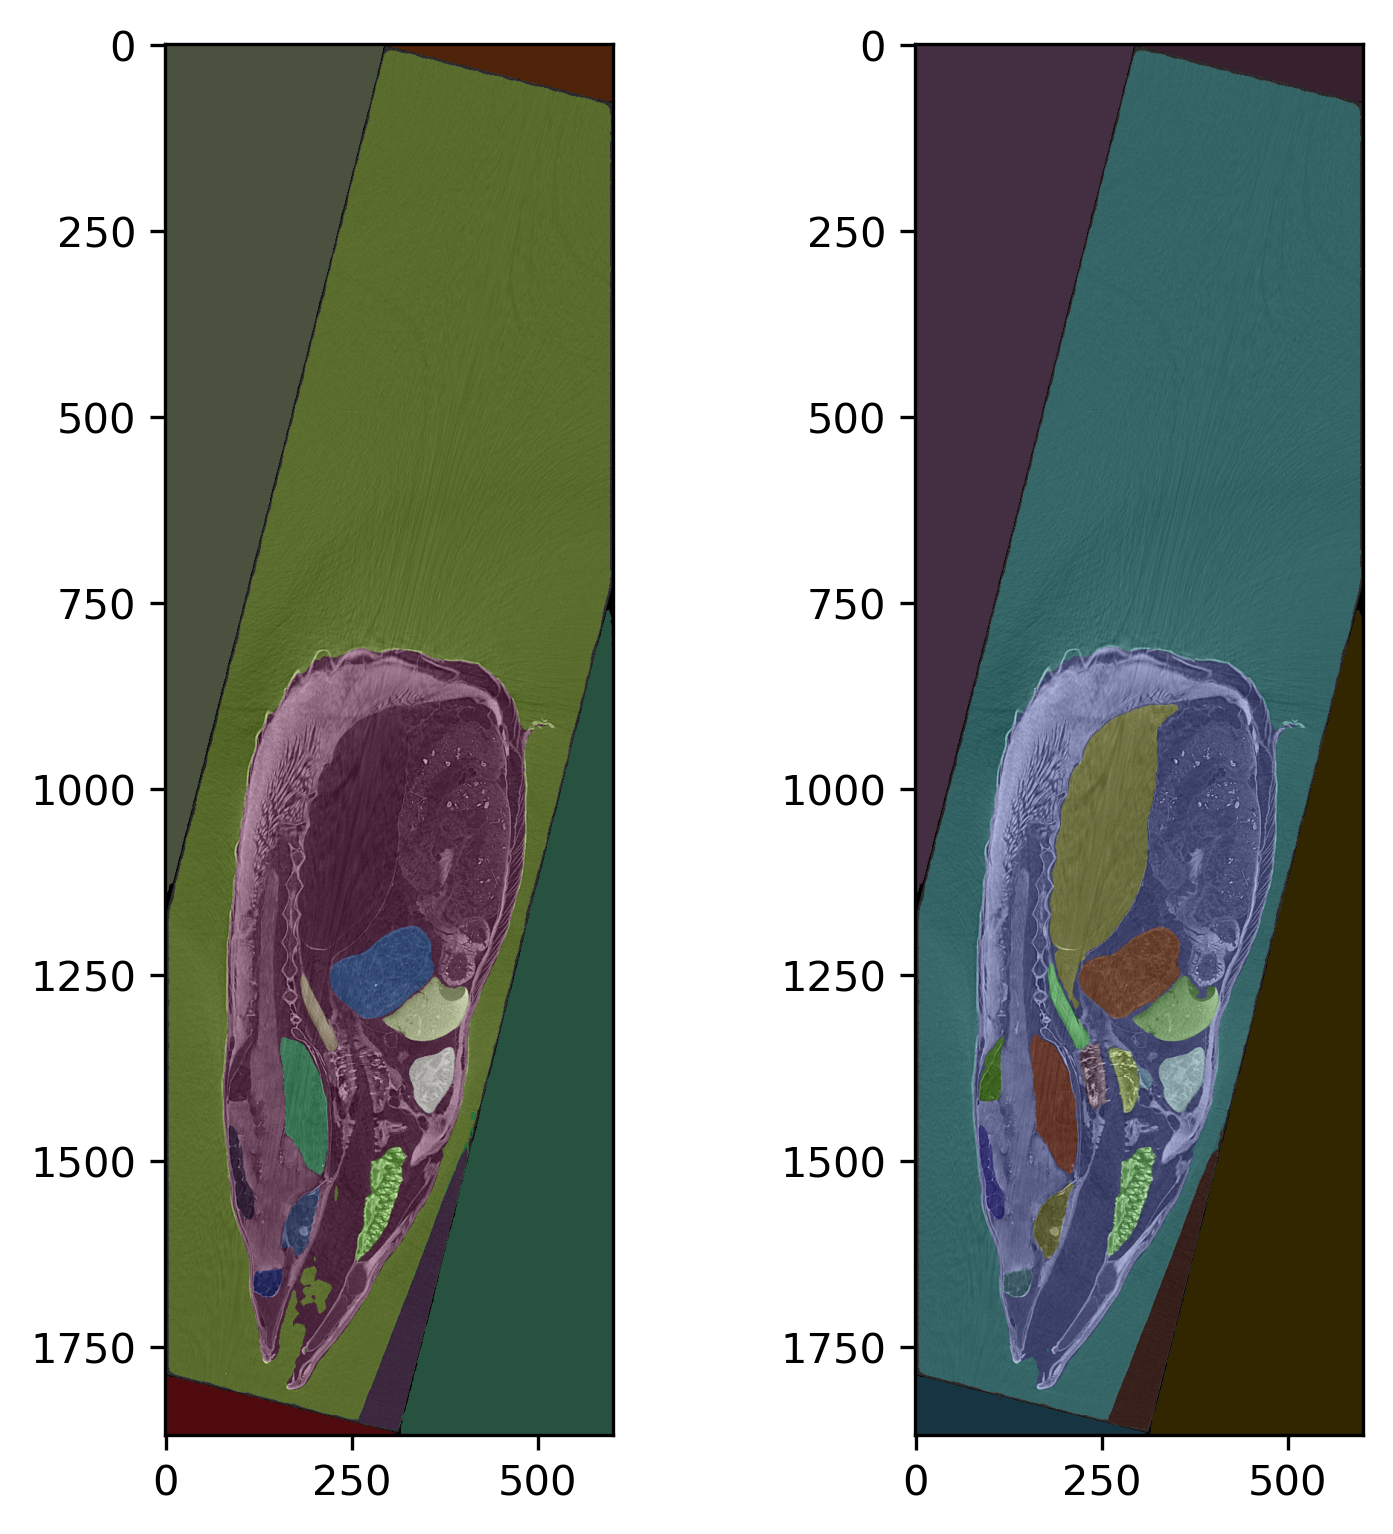

In [4]:
fig, axs = plt.subplot_mosaic(
    [
        ["200", "201"],
    ],
    layout="constrained",
    figsize=(5, 5),
    dpi=300,
)

axs["200"].imshow(image[:, :, 200], cmap="gray")
show_anns(masks200, axs["200"])
axs["201"].imshow(image[:, :, 201], cmap="gray")
show_anns(masks201, axs["201"])